In [1]:
#import all the necessary libraries and modules
import pandas as pd
import numpy as np
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
import keras
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_recall_curve
from funcsigs import signature
from keras.preprocessing.text import Tokenizer
import seaborn as sns
import time
import os
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import table

In [2]:
data = pd.read_csv('Dataset/smart_contracts_op_codes.csv') # importing dataset
data.columns=['smart_contract_address', 'op_code', 'vulnerability']
data.head()

,smart_contract_address,op_code,vulnerability
0,0x219f4ee903f78e78773e5d1e3520cfd507485bc6,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,1 0 0 0
1,0x560ed796aa8d23411b94b9d047ecdda39d4fcdeb,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,1 0 0 0
2,0xe726f97ff3c63dd71c1520c102adc39d1a2693ea,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,1 0 0 0
3,0x8ebac490495958b3804bb079e259340f0f53b69c,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,1 0 0 0
4,0x190700d69031db6b072a30577f9b3dbc53a320a1,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,1 0 0 0


In [3]:
# splitting the dataset into different types of vulnerabilities
vcs=pd.value_counts(data['vulnerability'])
labels1=vcs.index
v0=data[data['vulnerability'] == labels1[0]]
v1=data[data['vulnerability'] == labels1[1]]
v2=data[data['vulnerability'] == labels1[2]]
v3=data[data['vulnerability'] == labels1[3]]
v4=data[data['vulnerability'] == labels1[4]]

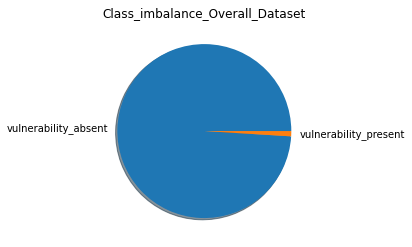

In [4]:
# showing class imbalance
# here, samples with vulnerabilities << samples without vulnerabilities
# so, in order to balance the class, we drop excess samples without vulnerabilities
sample_labels = np.array([v0.shape[0],v1.shape[0]+v2.shape[0]+v3.shape[0]+v4.shape[0]])
mylabels = ["vulnerability_absent", "vulnerability_present"]
plt.pie(sample_labels,shadow=True,labels=mylabels)
plt.title('Class_imbalance_Overall_Dataset')
plt.show()

In [5]:
# combining all samples with vulnerabilities into one dataset
positive_samples=pd.concat([v1,v2,v3,v4],axis=0)
positive_sample_size=positive_samples.shape
negative_samples=v0
negative_sample_size=negative_samples.shape
print('positive sample size = ',positive_sample_size)
print('negative sample size = ',negative_sample_size)

positive sample size =  (8640, 3)
negative sample size =  (884273, 3)


In [6]:
# conversion of op code to sequence of number using tokenization # NLP
def preprocess(df):
    n_most_common_words = 1000 
    max_len = 130
    tokenizer = Tokenizer(num_words=n_most_common_words, lower=False)
    tokenizer.fit_on_texts(df['op_code'].values)
    sequences = tokenizer.texts_to_sequences(df['op_code'].values)
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))
    X = pad_sequences(sequences, maxlen=max_len)
    return X

In [7]:
positive_samples.loc[:,['vulnerability']] = 1
negative_samples.loc[:,['vulnerability']]=0

C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [8]:
X=pd.concat([positive_samples,negative_samples],axis=0)
y=X.vulnerability
X=preprocess(X)

Found 150 unique tokens.


In [9]:
from imblearn.over_sampling import SMOTE
y=y.astype('int')
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)

In [10]:
X_train, X2, y_train, y2 = train_test_split(X_sm, y_sm, train_size=0.64)
X_test,X_val,y_test,y_val=train_test_split(X2,y2,train_size=.56)

In [11]:
y_train_cat = to_categorical(y_train, num_classes=2)
y_val_cat = to_categorical(y_val, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

In [12]:
# training of the parameter in network 
keras.backend.clear_session()
n_most_common_words = 1000 
model = Sequential()
model.add(Embedding(n_most_common_words, 128, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.6))
model.add(LSTM(64, dropout=0.6, recurrent_dropout=0.6))
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())
start_time = time.time()
history = model.fit(X_train, y_train_cat, epochs=2, batch_size=256, validation_split=0.0, validation_data=(X_val, y_val_cat),callbacks=[EarlyStopping(monitor='loss',patience=7, min_delta=0.0001)])
end_time = time.time()
print('Time taken for training: ', end_time-start_time)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 130, 128)          128000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 130, 128)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 177,538
Trainable params: 177,538
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2
4422/4422 [==============================] - 5316s 1s/step - loss: 0.0845 - acc: 0.9720 - val_loss: 0

In [13]:
y_predicted = model.predict(X_test, batch_size=32, verbose=1)
y_test = np.array(y_test)
arr = np.array(range(0,len(y_test),1))
for i in range(0,len(y_test),1):
    if(y_predicted[i][0]<y_predicted[i][1]):
        arr[i]=1
    else:
        arr[i]=0
y_predicted=arr

11142/11142 [==============================] - 249s 22ms/step


In [14]:
# other performance parameter evaluation
TP=0
TN=0
FP=0
FN=0
for i in range(0,len(y_predicted),1):
    if(y_test[i]==0):
        if(y_predicted[i]==0):
            TN+=1
        else:
            FP+=1
    else:
        if(y_predicted[i]==1):
            TP+=1
        else:
            FN+=1
print("true positives = ", TP)
print("false positives = ", FP)
print("true negatives = ", TN)
print("false negatives = ", FN)

true positives =  177867
false positives =  2517
true negatives =  175305
false negatives =  850


In [15]:
TPR=TP/(TP+FN)
FPR=FP/(FP+TN)
TNR=TN/(TN+FP)
FNR=FN/(FN+TP)
P=TP/(TP+FP)
R=TP/(TP+FN)
F1_score=2*P*R/(P+R)
acc=(TP+TN)/(TP+TN+FP+FN)
print("accuracy = ",acc*100,'%')
print("Precision = ",P*100,'%')
print("Recall = ",R*100,'%')
print("F1-score = ",F1_score*100,'%')

accuracy =  99.05564328166064 %
Precision =  98.60464342735497 %
Recall =  99.52438771913137 %
F1-score =  99.06238077866674 %


In [16]:
print('False negative rate = ',FN/(FN+TP)*100,'%')
print('True positive rate = ',TP/(TP+FN)*100,'%')

False negative rate =  0.4756122808686359 %
True positive rate =  99.52438771913137 %
